In [1]:
#Importation des bibliotheques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import gc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

from datasets import load_dataset

from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from model_ewc import ModelEWC

from tweet_dataset import TweetDataset
from neural_network import NeuralNetwork

Using cache found in C:\Users\Abdou/.cache\torch\hub\huggingface_pytorch-transformers_main


In [2]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_allocated()  # To check memory usage after clearing


0

In [3]:
#Definition de constante
SEED = 42 
BATCH_SIZE = 64 
DEVICE = "cuda" if torch.cuda.is_available else "cpu"

In [4]:
class OtherDataset(Dataset):
    def __init__(self, encodings,
                 tokenizer=torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased'),
                 max_length=180):
        self.encodings = encodings
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __getitem__(self, index):
        text = self.encodings.iloc[index] if hasattr(self.encodings, 'iloc') else self.encodings[index]
        inputs = self.tokenizer(
            text=text['text'],
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )
        target = text['label']
        # Use string comparison for labels
        target = 0 if target == 'Negative' else 1# if target == 'Positive' else [0, 0,1 ]
        
        return {
            'ids': inputs['input_ids'].squeeze(0).to(self.device),
            'token_type_ids': inputs['token_type_ids'].squeeze(0).to(self.device),
            'attention_mask': inputs['attention_mask'].squeeze(0).to(self.device),
            'target': torch.tensor(target, dtype=torch.float).to(self.device)
        }

    def __len__(self):
        return len(self.encodings)

Using cache found in C:\Users\Abdou/.cache\torch\hub\huggingface_pytorch-transformers_main


C:\Users\Abdou\anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Chargement des données Twitter...
Chargement des données Bluesky...
Entraînement sur la tâche Twitter...


C:\Users\Abdou\Documents\GitHub\Catastrophic_forgetting\model_ewc.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=self.t

✅ Modèle chargé depuis ./Model/model_T2_B1_500_nofreeze, entraîné pendant 2 époques.
Optimisation de lambda EWC...
Entraînement sur la tâche Bluesky avec EWC...


Métriques sur Twitter après EWC:


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


{'f1_score': 0.769, 'accuracy': 0.76, 'roc_auc': np.float64(0.761)}
Métriques sur Bluesky après EWC:


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]

{'f1_score': 0.703, 'accuracy': 0.78, 'roc_auc': np.float64(0.767)}
Affichage des courbes d'apprentissage...


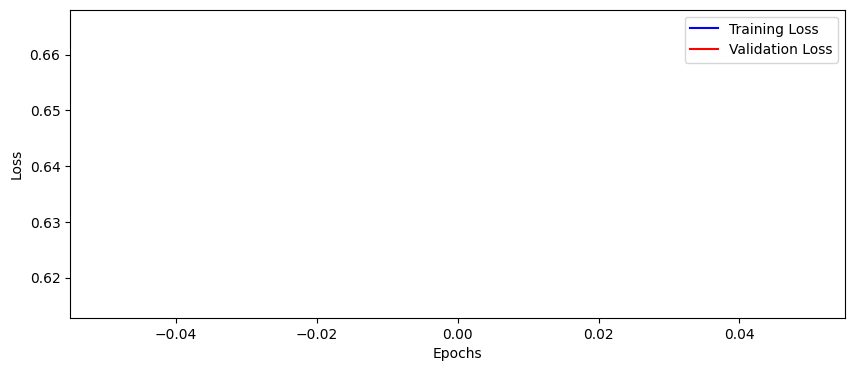

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64  # Reduced from 64
EPOCHS = 2
EPOCHS_BLUESKY = 1
NBDATA = 500
LR = 3e-5
FREEZE = False

# Set CUDA memory allocation configuration
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

def clear_gpu_memory():
    """Clear GPU memory cache"""
    gc.collect()
    torch.cuda.empty_cache()

def prepare_twitter_data():
    raw_dataset = load_dataset("EleutherAI/twitter-sentiment")
    dataset = raw_dataset.remove_columns(["source", "id"])
    dataset = dataset.shuffle(seed=48)

    # Sélection d'un sous-échantillon
    dataset = dataset["train"].select(range(NBDATA))

    # Split train/test
    dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=48)
    train_data = dataset['train']

    # Split test/validation
    generalisation_test = dataset['test'].train_test_split(test_size=0.5, shuffle=True, seed=48)
    validation_data = generalisation_test["train"]
    test_data = generalisation_test["test"]

    # Création des datasets et dataloaders
    train_dataset = TweetDataset(train_data)
    val_dataset = TweetDataset(validation_data)
    test_dataset = TweetDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

def prepare_bluesky_data():
    df = pd.read_csv('bluesky.csv')
    df = df.drop(['Unnamed: 0', 'score'], axis=1)
    df = df[df['label'].isin(['Positive', 'Negative'])]

    df = df.sample(n=1000, random_state=42)

    # Split train/test/validation
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Création des datasets et dataloaders
    train_dataset = OtherDataset(train_df)
    val_dataset = OtherDataset(val_df)
    test_dataset = OtherDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

def evaluate_lambda(trainer, ewc_lambda, train_loader_twitter, train_loader_bluesky, val_loader_bluesky, test_loader_bluesky):
    clear_gpu_memory()
    
    trainer.activate_ewc(ewc_lambda=ewc_lambda)
    trainer.compute_fisher_information(train_loader_twitter)
    
    trainer.set_loader(train_loader_bluesky, val_loader_bluesky)
    trainer.train(n_epochs=EPOCHS_BLUESKY)
    
    result = trainer.predict(test_loader_bluesky)
 
    trainer.model.to(DEVICE)
    clear_gpu_memory()
    
    return result

def main():
    clear_gpu_memory()
    
    # Préparation du modèle et des optimiseurs
    model = NeuralNetwork(n_labels=1, freeze_params=FREEZE).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    trainer = ModelEWC(model, loss_fn, optimizer)

    # Chargement des données
    print("Chargement des données Twitter...")
    train_loader_twitter, val_loader_twitter, test_loader_twitter = prepare_twitter_data()

    print("Chargement des données Bluesky...")
    train_loader_bluesky, val_loader_bluesky, test_loader_bluesky = prepare_bluesky_data()

    # Entraînement sur Twitter
    print("Entraînement sur la tâche Twitter...")
    trainer.set_loader(train_loader_twitter, val_loader_twitter)
    trainer.load_checkpoint('./Model/model_T2_B1_500_nofreeze')
    
    print("Optimisation de lambda EWC...")
    best_lambda = None
    best_score = -np.inf
    lambda_values = np.logspace(3, 10, num=9)

    scores = []
    
    # Create model copy for lambda optimization
    model_copy = copy.deepcopy(trainer.model)  # ← Nouvelle copie à chaque itération
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model_copy.parameters(), lr=LR)
    trainer_temp = ModelEWC(model_copy, loss_fn, optimizer)
    """
    for lmbda in lambda_values:
        model_copy = copy.deepcopy(trainer.model)  # ← Nouvelle copie à chaque itération
        loss_fn = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model_copy.parameters(), lr=LR)
        trainer_temp = ModelEWC(model_copy, loss_fn, optimizer)
        print(f" Test avec lambda = {lmbda}")
        
        score_dict = evaluate_lambda(trainer_temp, lmbda, train_loader_twitter, 
                                   train_loader_bluesky, val_loader_bluesky, test_loader_bluesky)
        print(score_dict)
        score = score_dict['f1_score'] + score_dict['accuracy'] + score_dict['roc_auc']
        scores.append((lmbda, score_dict, score))
        
        if score > best_score:
            best_score = score
            best_lambda = lmbda

    print(f"Meilleur lambda trouvé: {best_lambda}")

    print("Résultats des tests de lambda:")
    for entry in scores:
        lmbda, score_dict, combined_score = entry
        print(f"Lambda: {lmbda}, F1: {score_dict['f1_score']:.4f}, "
              f"Accuracy: {score_dict['accuracy']:.4f}, ROC AUC: {score_dict['roc_auc']:.4f}, "
              f"Combined: {combined_score:.4f}")

    clear_gpu_memory()
    """
    # Final training with best lambda
    trainer_temp.activate_ewc(ewc_lambda=3162277.6601683795)  # Use best_lambda instead of hardcoded value
    trainer_temp.compute_fisher_information(train_loader_twitter)

    print("Entraînement sur la tâche Bluesky avec EWC...")
    trainer_temp.set_loader(train_loader_bluesky, val_loader_bluesky)
    trainer_temp.train(n_epochs=EPOCHS_BLUESKY)

    print("Métriques sur Twitter après EWC:")
    twitter_metrics = trainer_temp.predict(test_loader_twitter)
    print(twitter_metrics)

    print("Métriques sur Bluesky après EWC:")
    bluesky_metrics = trainer_temp.predict(test_loader_bluesky)
    print(bluesky_metrics)

    print("Affichage des courbes d'apprentissage...")
    trainer_temp.plot_losses()

if __name__ == "__main__":
    main()